## Decision Tree Notebook for Galaxy Classification with SDSS DR18

Within this notebook we use a decision tree neural network to predict the type of star formation within a galaxy based upon the light from a target and its redshift.

This is classed as starburst or starforming, where starburst galaxies are classified as follows [(See Wikipedia for more)](https://en.wikipedia.org/wiki/Starburst_galaxy#:~:text=IC%2010.-,Definition,-%5Bedit%5D):

- Continued star-formation where the current star-formation rate (SFR) would exhaust the available gas reservoir in much less time than the age of the Universe.
- Continued star-formation where the current SFR would exhaust the available gas reservoir in much less time than the dynamical timescale of the galaxy (perhaps one rotation period in a disk type galaxy).
- The current SFR, normalized by the past-averaged SFR, is much greater than unity. This ratio is referred to as the "birthrate parameter".

The dataset used is from the eighteenth release of the Sloan Digital Sky Survey [(DR18)](https://www.sdss.org/dr18/), consisting of 100,000 galaxies either classified as starburst or starforming.

In [ ]:
import kagglehub #used to get the data from kaggle.com
from kagglehub import KaggleDatasetAdapter #used to fetch the specific dataset from kaggle
import pandas as pd #used for viewing and manipulating the data
import matplotlib.pyplot as plt #used for data visulisation
import sklearn as skl
from sklearn.model_selection import train_test_split as skl_tts
from sklearn.tree import DecisionTreeClassifier as skl_dtc
from sklearn.metrics import classification_report as skl_cr
from sklearn.metrics import accuracy_score as skl_as
from sklearn.tree import plot_tree as plt_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#DO NOT TOUCH THIS - IT WORKS
import sys, os #imports sys and os, allows for modifying the path to get functions
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), ".."))) #changes the path to include the py folder and its contents (parent folder)

from functions import * #calls all functions from functions.py


In [2]:
data = dataGrabber()

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data.head()

,objid,specobjid,ra,dec,u,g,r,i,z,modelFlux_u,modelFlux_g,modelFlux_r,modelFlux_i,modelFlux_z,petroRad_u,petroRad_g,petroRad_i,petroRad_r,petroRad_z,petroFlux_u,petroFlux_g,petroFlux_i,petroFlux_r,petroFlux_z,petroR50_u,petroR50_g,petroR50_i,petroR50_r,petroR50_z,psfMag_u,psfMag_r,psfMag_g,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,class,subclass,redshift,redshift_err
0,1237646587710669400,8175185722644649984,82.038679,0.847177,21.73818,20.26633,19.32409,18.64037,18.23833,2.007378,7.823640,18.63581,34.98175,50.64961,2.969037,4.252946,3.101782,3.461880,3.071923,2.559197,8.499634,30.32594,17.247060,36.44688,1.984029,1.835038,1.438609,1.638081,1.289375,22.58631,20.75200,21.66492,20.07646,19.43575,0.099951,0.311864,0.289370,0.270588,0.187182,GALAXY,STARFORMING,0.067749,0.000015
1,1237646588247540577,8175186822156277760,82.138894,1.063072,20.66761,19.32016,18.67888,18.24693,18.04122,5.403369,18.703640,33.76298,50.25997,60.73625,2.186902,2.625105,2.678123,2.594866,3.163450,4.333604,18.418770,51.06515,33.326970,62.45336,1.069268,1.278203,1.284687,1.263937,1.318443,21.31284,19.67125,20.23801,19.19277,18.85012,0.366549,0.516876,0.517447,0.552297,0.636966,GALAXY,STARFORMING,0.105118,0.000010
2,1237646588247540758,8175187097034184704,82.028510,1.104003,23.63531,21.19671,19.92297,19.31443,18.68396,0.295693,3.318924,10.73388,18.80136,33.58972,0.991798,1.644824,1.801951,1.749696,3.059948,0.165366,2.800386,17.09313,9.494298,51.73537,0.663606,0.947109,0.995734,0.987395,1.612933,23.92244,20.66160,21.83267,20.00731,19.42235,0.050000,0.417137,0.506950,0.549881,0.370166,GALAXY,STARFORMING,0.234089,0.000030
3,1237648702973083853,332152325571373056,198.544469,-1.097059,20.12374,18.41520,17.47202,17.05297,16.72423,8.920645,43.044740,102.61010,150.94260,204.31610,6.625083,4.719598,4.494591,4.777463,4.636094,12.330530,42.829570,149.63090,105.744500,203.88160,3.160263,2.093415,2.023142,2.156205,2.035692,21.34938,18.77640,19.75832,18.38868,18.03204,0.310763,0.356827,0.389345,0.388160,0.416660,GALAXY,STARFORMING,0.110825,0.000030
4,1237648702973149350,332154249716721664,198.706864,-1.046217,-9999.00000,-9999.00000,18.37762,18.13383,17.78497,0.000000,0.000000,44.56038,55.77801,76.90784,2.968866,2.969086,4.531428,4.184559,4.831804,0.000000,0.000000,60.36719,49.817800,84.34908,-9999.000000,-9999.000000,2.265335,2.094228,1.931134,-9999.00000,19.27078,-9999.00000,19.09511,19.02880,-9999.000000,-9999.000000,0.050000,0.050000,0.149973,GALAXY,STARFORMING,0.136658,0.000021


# Choosing features and selecting a target

These are the primary features we are using with our model from the data, as well as the target being the 'subclass' of the object. This can be easily changed however to any column from the dataset.

The features selected are as follows:
- u - the ultraviolet magnitude
- g - the green visible light magnitude
- r - the red visible light magnitude
- i - the infrared light at 7600 $\mathring{A}$
- z - the inrared light at 9100 $\mathring{A}$
- redshift - the redshift of the object

In [4]:
#main feature trying to find is subclass (starforming or starburst)
features = data[['u', 'g', 'r', 'i', 'z', 'redshift']]
target = data['subclass']

In [ ]:
test_size = 0.2 #splits the data into 80:20 ratio, using 80% of the data to test 20% of the data
random_state = 12 #acts as a seed to ensure same outcome each time
xTrain, xTest, yTrain, yTest = dataSplitting(features, target, test_size, random_state) #calls function to split data into test and training set

In [33]:
clf = skl_dtc(max_depth = 6, random_state = 12)
clf.fit(xTrain, yTrain)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,12
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [34]:
yPred = modelEvaluation(clf, xTest, yTest)

Accuracy of the model: 0.836

Classification Report:
              precision    recall  f1-score   support

   STARBURST       0.74      0.54      0.62      5023
 STARFORMING       0.86      0.94      0.90     14977

    accuracy                           0.84     20000
   macro avg       0.80      0.74      0.76     20000
weighted avg       0.83      0.84      0.83     20000



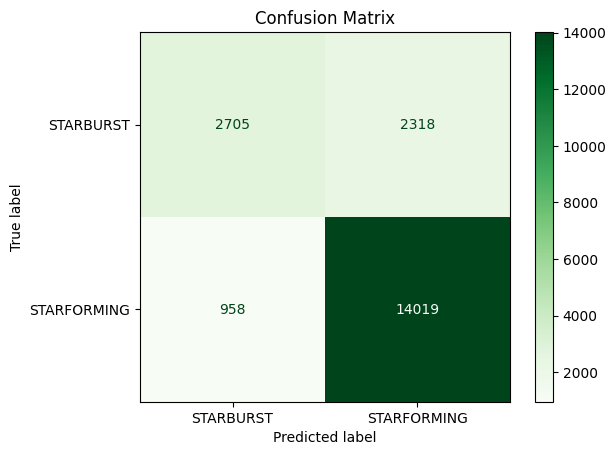

In [36]:
conf_mat = confusion_matrix(yTest, yPred)

display = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=clf.classes_)
display.plot(cmap=plt.cm.Greens, values_format='d')

plt.title("Confusion Matrix")
plt.show()